<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Feature Scaling

_Authors: Kiefer Katovich (SF), Joseph Nelson (DC)_

---

### Learning Objectives
- Explain the benefits of scaling data.
- Identify situations where scaling data is beneficial. 
- Scale data using Python and SKLearn.

### Lesson Guide
- [Introduction to feature scaling](#intro)
- [Why scale data?](#why-scale)
- [Centering](#centering)
- [Standardization](#standardization)
    - [Standardizing with sklearn's `StandardScaler`](#standard-scaler)
- [Normalization](#normalization)
    - [Normalizing with sklearn's `MinMaxScaler`](#minmax)
- [Independent practice scaling the wine dataset](#independent-practice)
- [Additional resources](#resources)

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<a id='intro'></a>

## Introduction to feature scaling

---

Scaling data is the process of increasing or decreasing the magnitude according to a fixed ratio. In other words, you change the size but not the shape of the data (the shape of the distribution is unchanged).

Some data scaling methods often change the *location* of the data as well. For example, when "centering" we take a distribution and change it's mean to be zero by subtracting the mean of the distribution from each data point in the distribution. While this is not technically "scaling", changing the location is often a component of the process and preserves the shape of the data (it just shifts it around).


<a id='why-scale'></a>

## Why should we scale data?

---

**There are a number of good reasons why we scale our data:**
- To handle disparities in units.
- Cut computational expense.
- Improve model performance (Especially Machine Learning).
- We scale for models to prevent the steps on different axes from varying widely.

**It’s rarely a bad idea to scale your data!** 

<a id='centering'></a>

## Centering: changing the location of data

---

We can start with the simplest transformation example: centering. If we have a distribution of values $X$, then to center our data to a new distribution $X_c$:

### $$ X_c = X - \bar{X} $$

### Benefits of centering data

The primary benefit of centering your predictor data in linear modeling is so **the intercept represents the estimate of the target when all predictors are at their mean value.**

If we don't center, the intercept is the estimate of our model when all predictors are at value 0. It often makes the intercept much more interpretable when you center your predictors.

### Centering example: baseball player height and weight

Load in the dataset on the heights, weights, and ages of baseball players.

In [2]:
baseball = pd.read_csv('../datasets/baseball_height_weight.csv')
baseball.columns

Index([u'name', u'team', u'position', u'height_in', u'weight_lb', u'age'], dtype='object')

**Plot the distribution of the heights and weights below:**

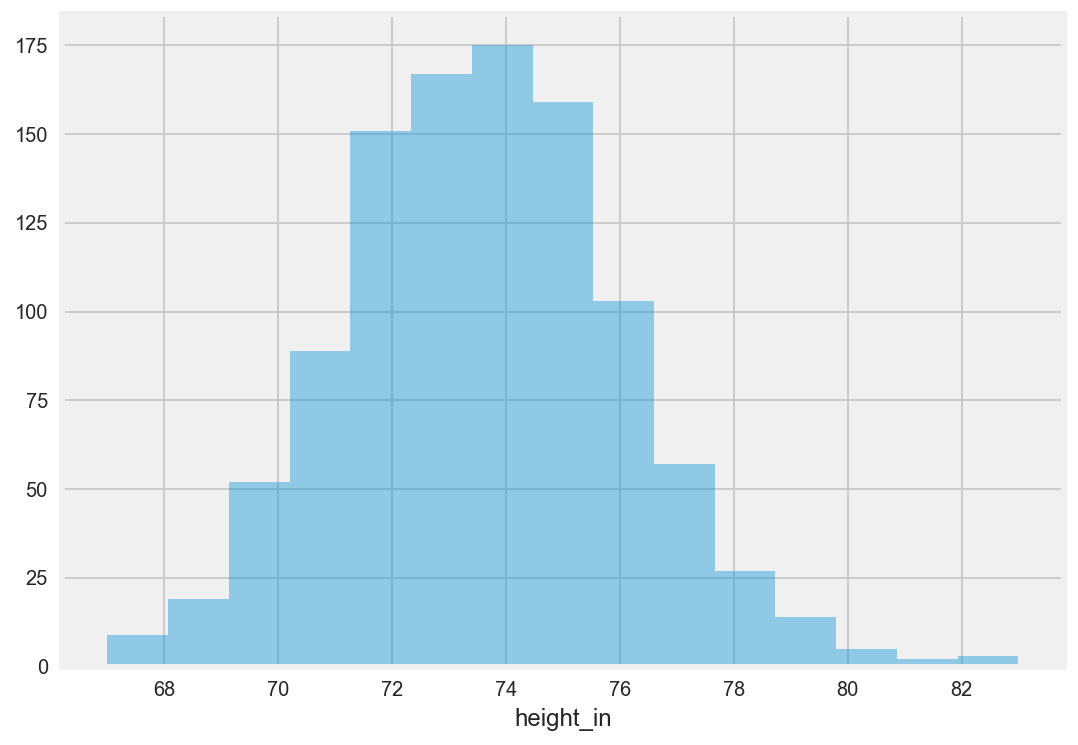

In [3]:
fig, ax = plt.subplots(figsize=(8,6))
sns.distplot(baseball.height_in, bins=15, kde=False)

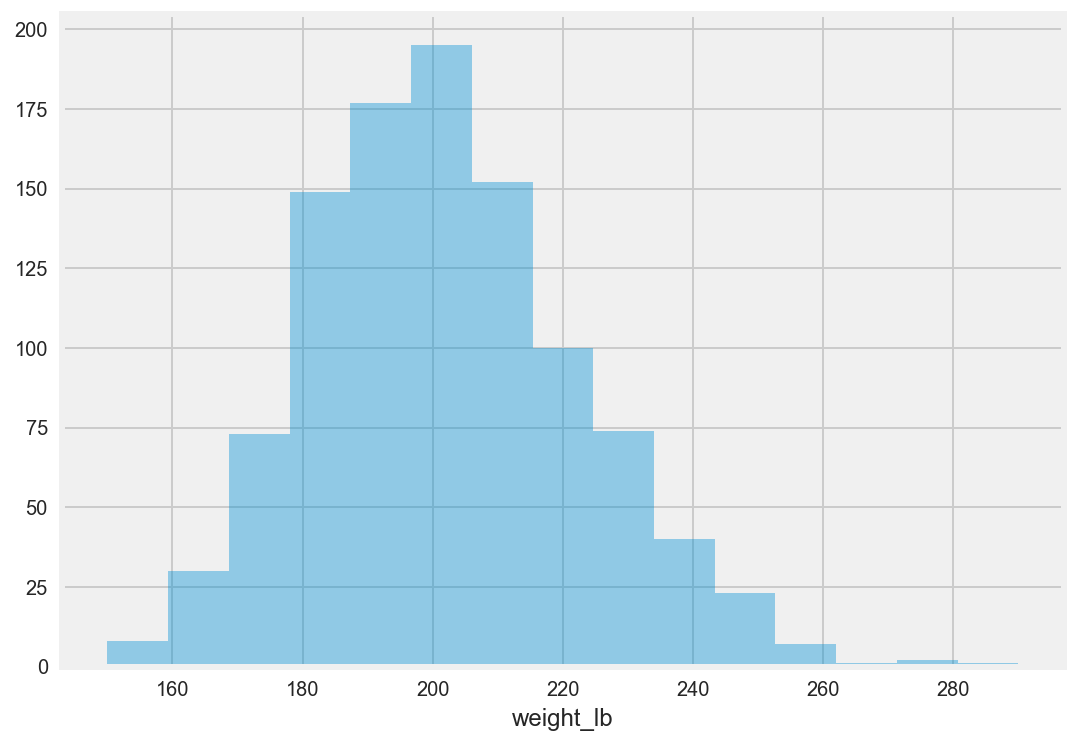

In [4]:
fig, ax = plt.subplots(figsize=(8,6))
sns.distplot(baseball.weight_lb, bins=15, kde=False)

**Construct a linear regression predicting weight from height. Interpret the value of the intercept and the coefficient from this model.**

In [17]:
from sklearn.linear_model import LinearRegression
import patsy

# we can use patsy to quickly create dataframes from columns in a dataframe
# i remove the intercept patsy usually puts in since i'm going to use sklearn.
y, X = patsy.dmatrices('weight_lb ~ height_in -1', data=baseball, return_type='dataframe')
y = y.values.ravel()


linreg = LinearRegression()
linreg.fit(X, y)
print 'Intercept:', linreg.intercept_
print 'Height coef:', linreg.coef_


Intercept: -154.893184515
Height coef: [ 4.83820825]


In [6]:
# The intercept, -154, is the estimated weight of a baseball player when their height is 0 inches.
# The 4.8 coefficient on height is the number of pounds more a player is estimated to weigh for each
# inch of height.

**Center the height variable and re-run the regression with the centered height. Interpret the new intercept and coefficient.**

In [18]:
baseball['height_ctr'] = baseball.height_in - baseball.height_in.mean()

# i remove the intercept patsy usually puts in since i'm going to use sklearn.
y, X = patsy.dmatrices('weight_lb ~ height_ctr -1', data=baseball, return_type='dataframe')
y = y.values.ravel()

linreg = LinearRegression()
linreg.fit(X, y)
print 'Intercept:', linreg.intercept_
print 'Height centered coef:', linreg.coef_

Intercept: 201.671511628
Height centered coef: [ 4.83820825]


In [19]:
print np.mean(baseball.height_in)

73.6976744186


In [9]:
# The intercept, 201, is the estimated weight of a baseball player of AVERAGE height (73.69 in).
# The 4.8 coefficient on height is the number of pounds more a player is estimated to weigh for each
# inch of height. This does not change!

<a id='standardization'></a>

## Standardization

---

The most common method of scaling is standardization. In standardization we first center the data, then we divide by the standard devation to enforce that the standard deviation of the variable is one:

### $$ X_{std} = \frac{X - \bar{X}}{s_{X}} $$

### Benefits of standardizing data

There are many benefits to standardizing our data, especially when we have more than one predictor:
- Intercepts are interpreted as the estimate when all predictors are at their mean value.
- Coefficients are in units of standard deviations of the original predictors. This allows for direct comparison of the magnitude of impact between different predictors.
- Optimization methods (minimizing loss functions) are faster and more stable.
- It is required for regularization penalties where the magnitude of coefficients for different predictors must have the same meaning.
- In K-Nearest Neighbors methods it is necessary if you want features to contribute equally since these models use the distance between observations calculated from the features.
- K-means clustering is affected by the scale of the data and standardizing the features will prevent variables from dominating simply based on their scale.
- In logistic regression, neural networks, and support vector machines unscaled data can result in a disproportionate effect of some data points over others.

> **Note:** In ordinary linear regression centering and scaling your variables does *not* impact the amount of variance you can account for. This is because we are only moving and and adjusting the magnitude of the distribution: the shape of the distribution does not change.

### Standardization example

First, plot the original height variable against the weight variable. Use seaborn's `sns.jointplot`. 

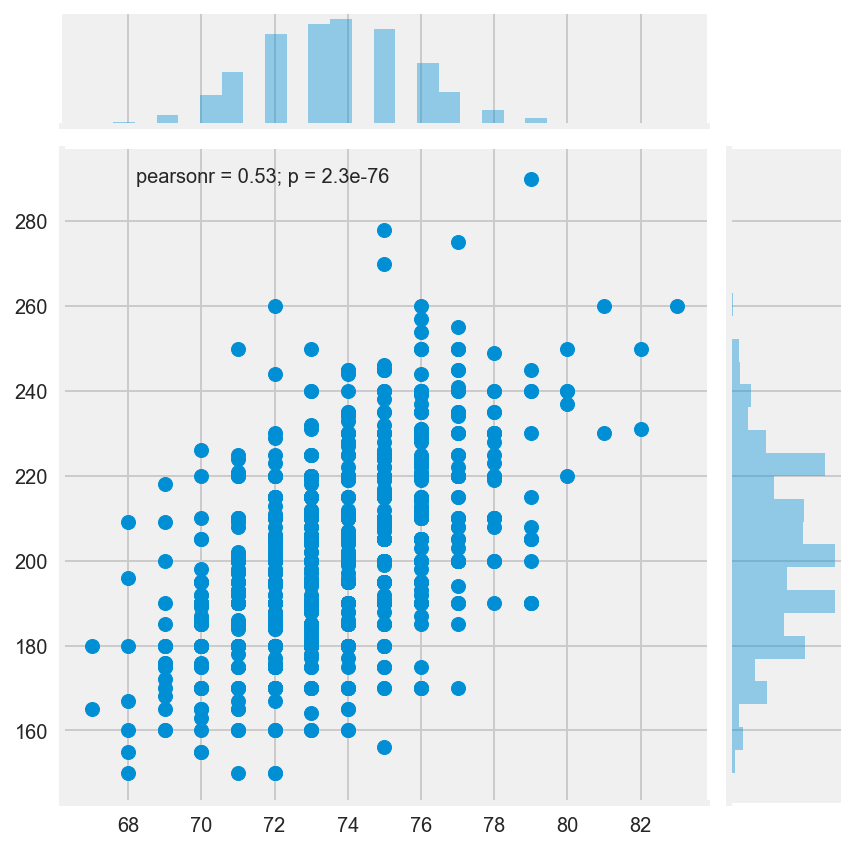

In [20]:
sns.jointplot(baseball.height_in.values, baseball.weight_lb.values)

**Create standardized versions of the height and weight variables.**

In [21]:
baseball['height_std'] = (baseball.height_in - baseball.height_in.mean()) / baseball.height_in.std()
baseball['weight_std'] = (baseball.weight_lb - baseball.weight_lb.mean()) / baseball.weight_lb.std()

**Plot the standardized weight against the height. Notice the distribution shapes and relationship between the variables is unchanged.**

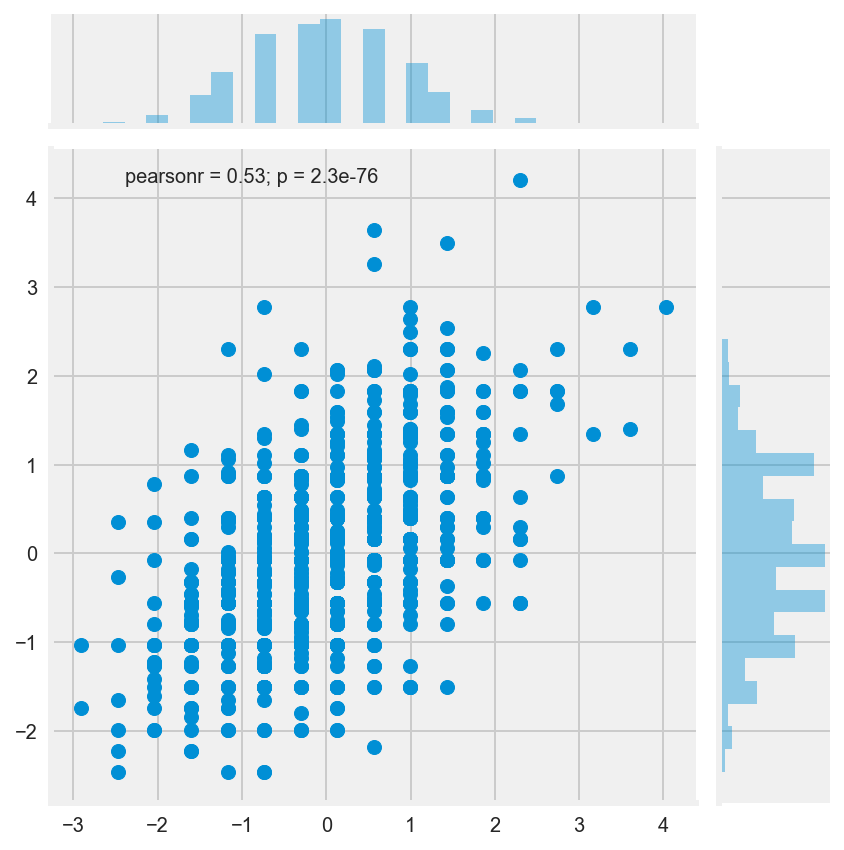

In [22]:
sns.jointplot(baseball.height_std.values, baseball.weight_std.values)

<a id='standard-scaler'></a>
### Using sklearn's `StandardScaler`

Sklearn comes packaged with a class `StandardScaler` that will preform the standardization on a matrix for you. 

Load in the package like so:

```python
from sklearn.preprocessing import StandardScaler
```

Once instantiated, the standard scaler object has three primary methods built in:
- `.fit(X)` will calculate the mean and standard deviations for each column of X
- `.transform(X)` will take X and return a transformed version of X where each column is standardized according to their means and standard deviations (must have run `.fit()` first).
- `.fit_transform(X)` combines the `.fit()` method and the `.transform()` method.

**Use `StandardScaler` to standardize a predictor matrix containing height and weight from the baseball data.**

In [33]:
from sklearn.preprocessing import StandardScaler

# initialize the Scaler
ss = StandardScaler()

# Fit the data using the scaler (scale the data)
Xstd = ss.fit_transform(baseball[['height_in','weight_lb']].values)
print Xstd.mean(), Xstd.std()

7.65967823191e-16 1.0


**Build a linear regression predicting age from the standardized height and weight data. Interpret the coefficients.**

In [34]:
lr = LinearRegression()
lr.fit(Xstd, baseball.age.values)

print 'Intercept:', lr.intercept_
print 'Coefs:', lr.coef_

Intercept: 28.7341569767
Coefs: [-0.95285142  1.18796454]


In [15]:
# A 1 standard deviation increase in height estimates -0.95 years age.
# A 1 standard deviation increase in weight estimates 1.18 years age.

<a id='normalization'></a>

## Normalization

---

Normalization most often refers to the process of "normalizing" a variable to be between 0 and 1. Think of this as squishing the variable to be constrained to a specific range.

### $$ X_{norm} = \frac{X - min(X)}{max(X) - min(X)} $$

This type of normalization is typically referred to as "min-max scaling". 

### Benefits of normalization

Typically standardization is preferred to min-max normalization. However, there are some applications where min-max scaling would be preferable:
- Neural networks often require their inputs to be bounded between 0 and 1. 
- In images, for example, where pixels can only take on a specific range of RGB values, data may have to be normalized.

<a id='minmax'></a>
### Normalization with `MinMaxScaler`

Sklearn also has a class for normalization called `MinMaxScaler`:

```python
from sklearn.preprocessing import MinMaxScaler
```

The `MinMaxScaler` has the same `fit()`, `transform()`, and `fit_transform()` methods.

**Normalize the age, height, and weight variables using `MinMaxScaler`**

In [23]:
from sklearn.preprocessing import MinMaxScaler

X = baseball[['age','height_in','weight_lb']]

mms = MinMaxScaler()
Xn = mms.fit_transform(X)

**Look at the min and max ranges for the normalized matrix.**

In [24]:
print Xn.min(axis=0)
print Xn.max(axis=0)

[ 0.  0.  0.]
[ 1.  1.  1.]


In [25]:
print Xn.std(axis=0)

[ 0.15643887  0.14412335  0.14988388]


**Plot the normalize height against the normalized weight.**

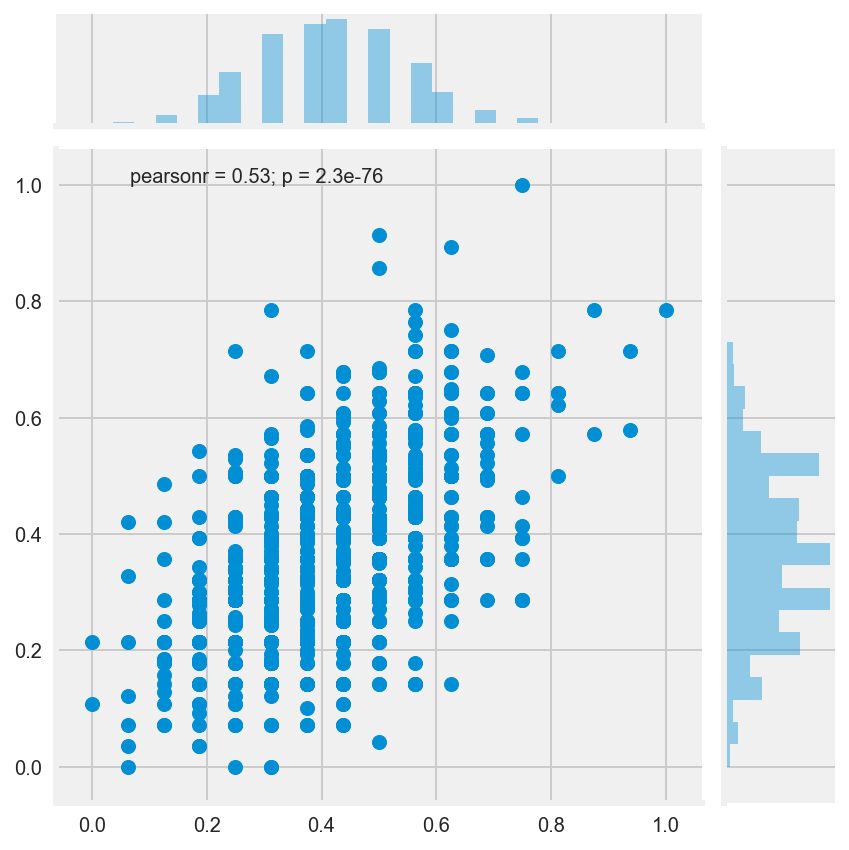

In [26]:
sns.jointplot(Xn[:,1], Xn[:,2])

<a id='independent-practice'></a>

## Independent practice: scaling the wine dataset

---

Below you'll load in the wine quality dataset. This dataset contains a variety of features for different types/brands of wine. 

**You should:**
1. Load and examine the data.
2. Create a target variable for wine quality.
3. Create a predictor matrix with variables of your choice.
4. Create a standardized and normalized version of your predictor matrix.
5. Using cross-validation, calculate the average $R^2$ score for wine quality using the original predictors, the standardized predictors, and the normalized predictors.

**1. Load and examine the data.**

In [27]:
wine = pd.read_csv('../datasets/winequality_merged.csv')

In [28]:
wine.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  red_wine  
0      9.4        5         1  
1      9.8        5         1  
2      9.8        5         1  
3      9.8        6         1  
4      9.4        5         1

In [29]:
wine.dtypes

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
red_wine                  int64
dtype: object

**2. Create a target variable for wine quality.**

In [30]:
 quality = wine.quality.values
wine.quality.describe()

count    6497.000000
mean        5.818378
std         0.873255
min         3.000000
25%         5.000000
50%         6.000000
75%         6.000000
max         9.000000
Name: quality, dtype: float64

**3. Create a predictor matrix with variables of your choice.**

In [31]:
X = wine[['fixed acidity','residual sugar','sulphates','alcohol']]
X.head()

fixed acidity  residual sugar  sulphates  alcohol
0            7.4             1.9       0.56      9.4
1            7.8             2.6       0.68      9.8
2            7.8             2.3       0.65      9.8
3           11.2             1.9       0.58      9.8
4            7.4             1.9       0.56      9.4

**4. Create a standardized and normalized version of your predictor matrix.**

In [35]:
ss = StandardScaler()
mms = MinMaxScaler()

Xs = ss.fit_transform(X)
Xn = mms.fit_transform(X)

In [36]:
print X.shape, Xs.shape, Xn.shape

(6497, 4) (6497, 4) (6497, 4)


**5. Using cross-validation, calculate the average $R^2$ score for wine quality using the original predictors, the standardized predictors, and the normalized predictors.**

In [37]:
from sklearn.model_selection import cross_val_score

lr = LinearRegression()

raw_r2 = cross_val_score(lr, X, quality, cv=10)
std_r2 = cross_val_score(lr, Xs, quality, cv=10)
norm_r2 = cross_val_score(lr, Xn, quality, cv=10)

print 'Original mean CV-R2:', np.mean(raw_r2), 'std CV-R2:', np.std(raw_r2)
print 'Standadized mean CV-R2:', np.mean(std_r2), 'std CV-R2:', np.std(std_r2)
print 'Normalized mean CV-R2:', np.mean(norm_r2), 'std CV-R2:', np.std(norm_r2)



Original mean CV-R2: 0.187032279601 std CV-R2: 0.0627632182558
Standadized mean CV-R2: 0.187032279601 std CV-R2: 0.0627632182558
Normalized mean CV-R2: 0.187032279601 std CV-R2: 0.0627632182558


<a id='resources'></a>

## Additional resources

---

[About feature scaling and normalization.](http://sebastianraschka.com/Articles/2014_about_feature_scaling.html)